## **프로젝트: Make A Segmentation Map**
1. Augmentation 방법 적용 
2. Skip-connection있는 U-Net Generator 사용 
3. val 폴더 내 이미지에서 test set split
4. 실제 사진 순서로 이미지 결과 시각화 - 스케치, 생성된 사진
5. 모델 학습 시각화 - 10 epoch 이상, 중간 손실 값에 대한 로그 

## **루브릭**
1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.
  - 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.
2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.
  - U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.
3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.
  - 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

In [8]:
# ! pip install tensorflow-datasets

In [9]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers, losses
import numpy as np
import os


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


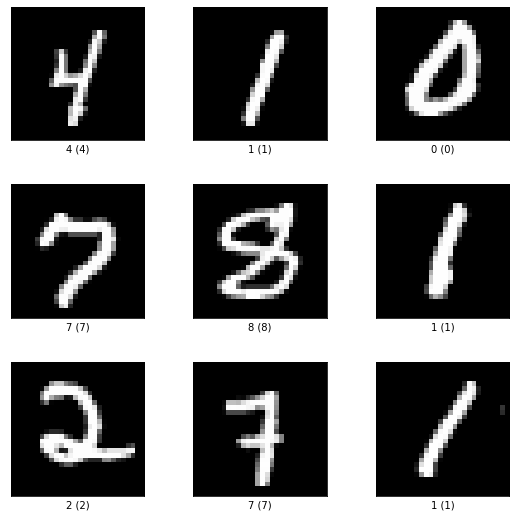

✅


In [2]:
mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

Label : tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


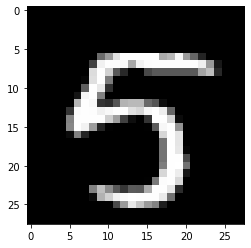

In [3]:
for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

In [6]:
# GAN - Generator
class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

# CGAN - Generator
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


In [7]:
# GAN - Discriminator
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
# DCGAN - Discriminator
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


In [ ]:
bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")
